In [1]:

# Cell 2 — Imports and versions
# shapes/units: n/a (diagnostic only)
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sys

import skfem
from skfem import MeshTri, ElementTriP1, Basis, asm, solve, condense, BilinearForm, LinearForm
from skfem.models.poisson import laplace

from pysensors.reconstruction import SSPOR
from pysensors.basis import SVD

print("Python", sys.version)
print("numpy", np.__version__, "| scipy", scipy.__version__, "| matplotlib", matplotlib.__version__)
print("scikit-fem", skfem.__version__)


Python 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
numpy 2.2.6 | scipy 1.15.3 | matplotlib 3.10.6
scikit-fem 11.0.0


In [2]:

# Cell 3 — FEM helpers: mesh, RHS, solver
# shapes: xy -> (S,2), vectors -> (S,), matrices sparse (S,S). Units: nondimensional.
from typing import Tuple

def make_mesh(n: int = 80):
    """Unit square [0,1]^2 triangulated. Returns mesh, coordinates (S,2) and P1 basis."""
    m = MeshTri.init_symmetric().refined(int(np.log2(max(n,2)/2)))
    e = ElementTriP1()
    basis = Basis(m, e)
    xy = m.p.T  # (S,2)
    return m, xy, basis

def poisson_rhs(basis: Basis, cx: float, cy: float, sigma: float = 0.08):
    """Gaussian load centered at (cx,cy). Returns assembled load vector f (S,)."""
    @LinearForm
    def rhs(v, w):
        x, y = w.x
        g = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
        return g * v
    f = asm(rhs, basis)  # (S,)
    return f

def solve_poisson(basis: Basis, f: np.ndarray) -> np.ndarray:
    """Solve -Δu = f with u=0 on ∂Ω. Returns u (S,)."""
    A = asm(laplace, basis)            # (S,S) sparse
    D = basis.get_dofs().all()         # Dirichlet dofs
    b = f.copy()
    u = solve(*condense(A, b, D=D))    # (S,)
    return u


In [3]:

# Cell 4 — Build training/testing snapshots
# shapes: X -> (N,S) where N=n_snaps, S=#nodes. Units: u is nondimensional.
def make_snapshots(n_snaps: int = 80, sigma: float = 0.08, seed: int = 0):
    rng = np.random.default_rng(seed)
    m, xy, basis = make_mesh(n=80)
    centers = rng.uniform(0.2, 0.8, size=(n_snaps, 2))  # avoid corners
    X = np.empty((n_snaps, xy.shape[0]))                # (N,S)
    for i, (cx, cy) in enumerate(centers):
        f = poisson_rhs(basis, cx, cy, sigma=sigma)     # (S,)
        u = solve_poisson(basis, f)                     # (S,)
        X[i] = u
    return X, xy

# quick smoke test
X, xy = make_snapshots(6, seed=42)
print("snapshots shape:", X.shape, "| nodes S:", xy.shape[0])


snapshots shape: (6, 2113) | nodes S: 2113


In [4]:

# Cell 5 — Train sensors with SVD basis + SSPOR
# shapes: X_train -> (N_train,S); selected sensors idx -> (m,)
def train_sensors(X_train: np.ndarray, n_sensors: int = 40, n_modes: int = 30):
    basis = SVD(n_basis_modes=n_modes)
    model = SSPOR(basis=basis, n_sensors=n_sensors)
    model.fit(X_train)  # rows=snapshots, cols=features
    return model, model.selected_sensors

# smoke test
model_tmp, idx_tmp = train_sensors(X, n_sensors=20, n_modes=12)
print("selected sensors (first 10):", idx_tmp[:10])


selected sensors (first 10): [1008  348 2037 1474 1668  313 1883  513  605  817]


[shapes] X_train=(70, 2113), X_test=(10, 2113), sensors=40, nodes=2113
[RMSE] unregularized=7.461e-04, regularized=4.111e-04


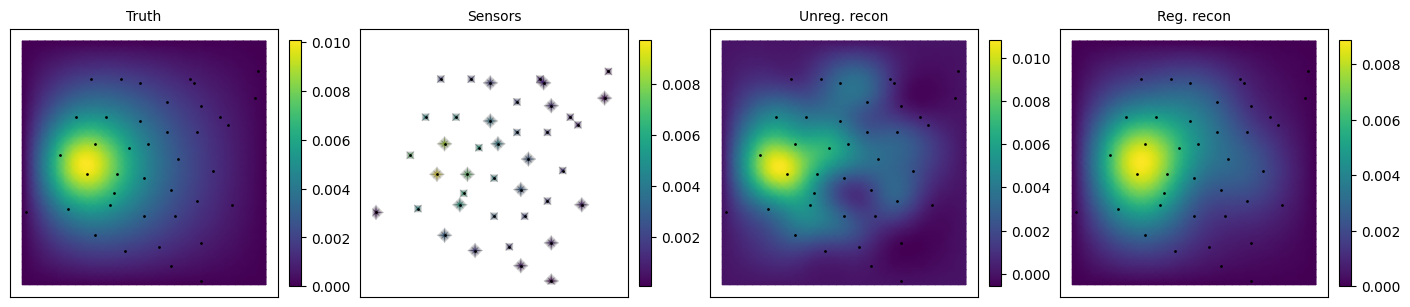

(array([ 672, 2009,  663, 1645, 1230, 1795, 1264,  439, 1785, 1016],
       dtype=int32),
 (np.float64(0.0007460912811537122), np.float64(0.0004110580867623878)))

In [5]:

# Cell 6 — End-to-end demo with gappy noisy sensors + two recon methods
# shapes: as printed; Units: noise_sigma is stddev added to sensor readings (same units as u).
from matplotlib.tri import Triangulation
import matplotlib.tri as mtri

def demo(n_train=70, n_test=10, n_sensors=40, n_modes=30, noise_sigma=1e-3, seed=1):
    X, xy = make_snapshots(n_snaps=n_train + n_test, seed=seed)
    X_train, X_test = X[:n_train], X[n_train:]
    model, idx = train_sensors(X_train, n_sensors=n_sensors, n_modes=n_modes)

    rng = np.random.default_rng(seed + 123)
    Y = X_test[:, idx] + noise_sigma * rng.standard_normal(size=(n_test, n_sensors))  # (n_test,m)

    # Unregularized (pseudoinverse)
    Xhat_unreg = model.predict(Y, method='unregularized')  # (n_test,S)
    # Regularized (default): supply prior + noise
    Xhat_reg = model.predict(Y, prior='decreasing', noise=noise_sigma)  # (n_test,S)

    rmse = lambda A, B: np.sqrt(np.mean((A - B)**2))
    r1, r2 = rmse(X_test, Xhat_unreg), rmse(X_test, Xhat_reg)

    print(f"[shapes] X_train={X_train.shape}, X_test={X_test.shape}, sensors={len(idx)}, nodes={X.shape[1]}")
    print(f"[RMSE] unregularized={r1:.3e}, regularized={r2:.3e}")

    # Plot one example
    tri = mtri.Triangulation(xy[:, 0], xy[:, 1])
    k = 0
    fig, axs = plt.subplots(1, 4, figsize=(14, 3.3), constrained_layout=True)
    titles = ["Truth", "Sensors", "Unreg. recon", "Reg. recon"]
    fields = [X_test[k], np.nan * np.ones_like(X_test[k]), Xhat_unreg[k], Xhat_reg[k]]
    fields[1][idx] = X_test[k, idx]  # show only sensor samples

    for ax, z, t in zip(axs, fields, titles):
        im = ax.tripcolor(tri, z, shading='gouraud')
        ax.plot(xy[idx, 0], xy[idx, 1], 'k.', ms=2)
        ax.set_aspect('equal')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(t, fontsize=10)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.show()

    return dict(idx=idx, rmse_unreg=r1, rmse_reg=r2, xy=xy)

out = demo()
out['idx'][:10], (out['rmse_unreg'], out['rmse_reg'])



--- n_sensors=20 ---
[shapes] X_train=(80, 2113), X_test=(10, 2113), sensors=20, nodes=2113
[RMSE] unregularized=1.535e-03, regularized=5.758e-04


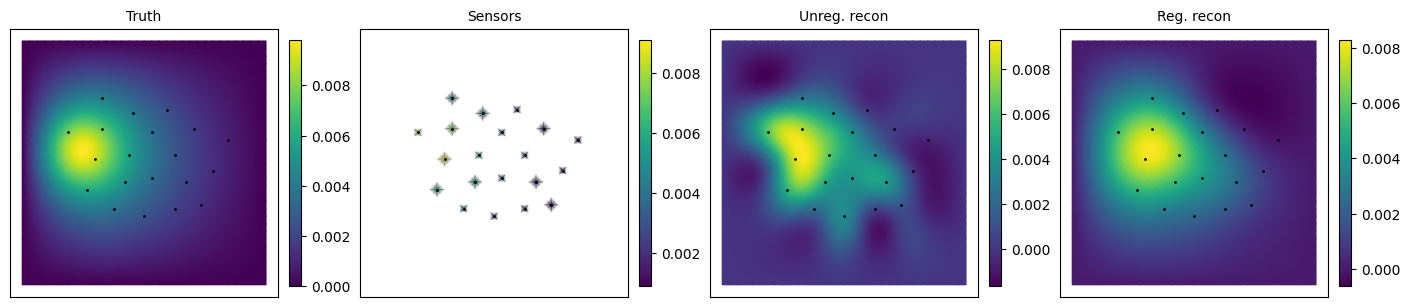


--- n_sensors=30 ---
[shapes] X_train=(80, 2113), X_test=(10, 2113), sensors=30, nodes=2113
[RMSE] unregularized=8.690e-04, regularized=5.190e-04


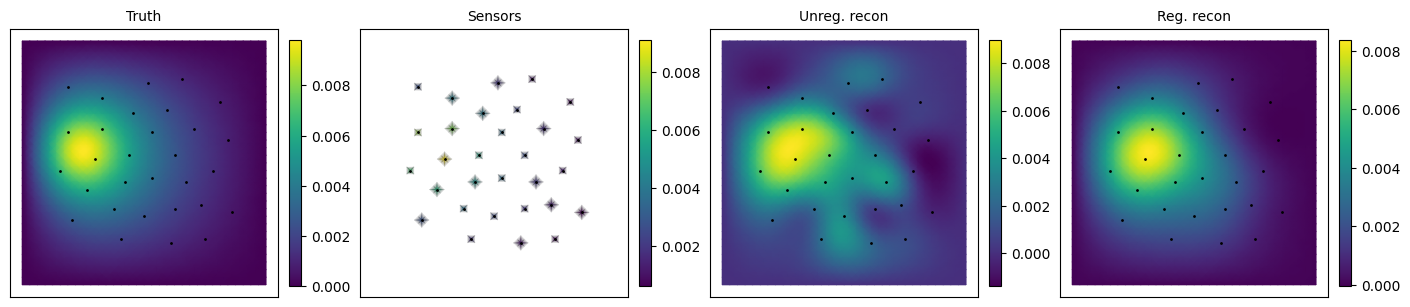


--- n_sensors=40 ---
[shapes] X_train=(80, 2113), X_test=(10, 2113), sensors=40, nodes=2113
[RMSE] unregularized=8.158e-04, regularized=4.569e-04


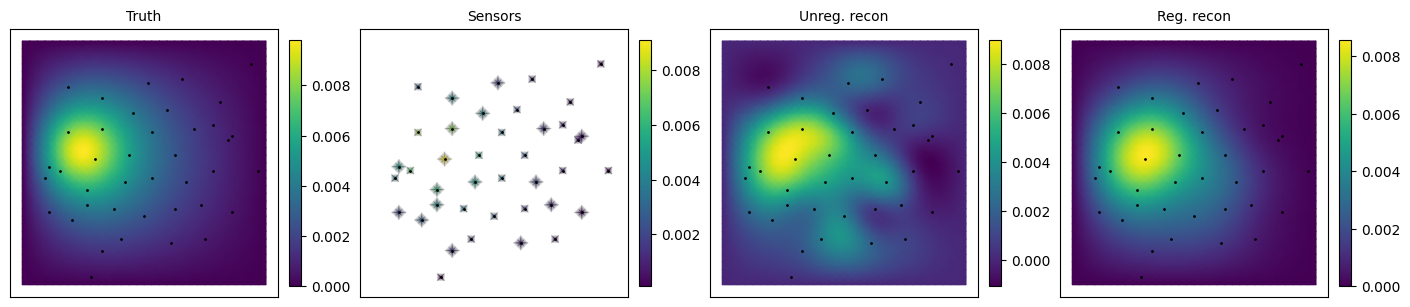


--- n_sensors=60 ---
[shapes] X_train=(80, 2113), X_test=(10, 2113), sensors=60, nodes=2113
[RMSE] unregularized=6.691e-04, regularized=4.186e-04


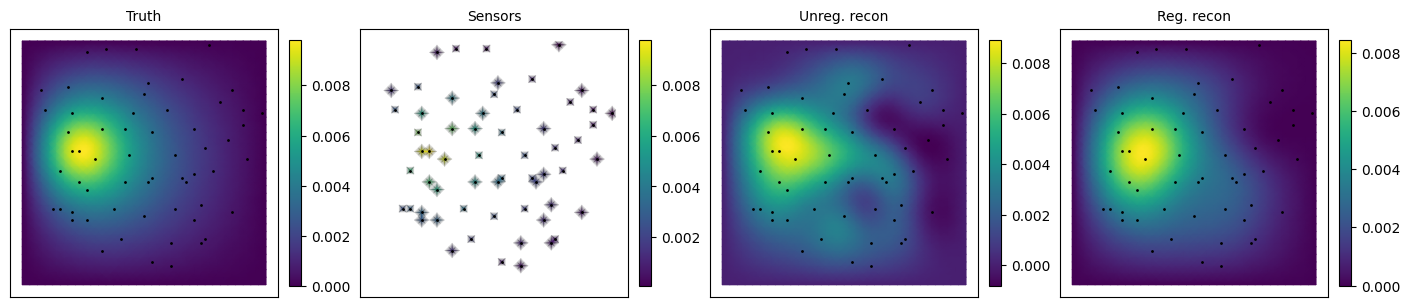

In [6]:

# Cell 7 — Quick tuning sweep for sensors/modes (prints wall-clock if you time it externally)
def sweep():
    for m in [20, 30, 40, 60]:
        print(f"\n--- n_sensors={m} ---")
        _ = demo(n_sensors=m, n_modes=30, n_train=80, n_test=10, noise_sigma=1e-3, seed=3)
sweep()



## Constrained placement (optional next step)
PySensors exposes `pysensors.optimizers.{QR, CCQR, GQR, TPGR}` and geometric constraint helpers.
Swap `SSPOR(..., optimizer=...)` and pass indices of forbidden/required regions and/or spacing radius `r`.
See the package docs for examples.
